In [16]:
import xarray as xr
import numpy as np
import pandas as pd

In [48]:
COEF_DRY_TO_CARBON = 0.40

In [17]:
obs = pd.read_csv("./zoo_1987_1999.csv")
obs.columns = ["month", "zoo"]
obs = obs.set_index("month")
obs

,zoo
month,
1,2.9
2,3.7
3,1.2
4,1.9
5,4.5
6,9.8
7,11.0
8,9.7
9,8.7


<Axes: xlabel='month'>

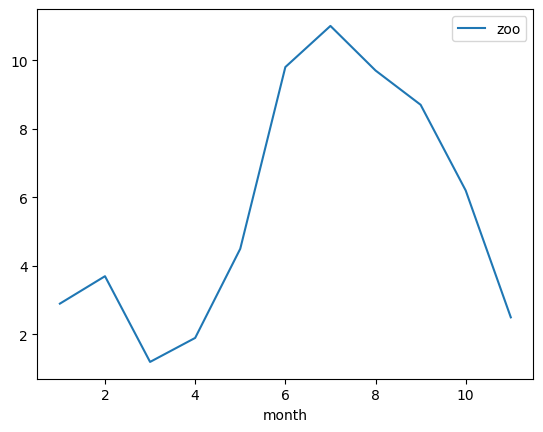

In [22]:
obs.plot()

# Climato


In [19]:
time_in_month = pd.date_range(start="1987-01-01", end="1999-12-01", freq="MS")

<Axes: xlabel='time'>

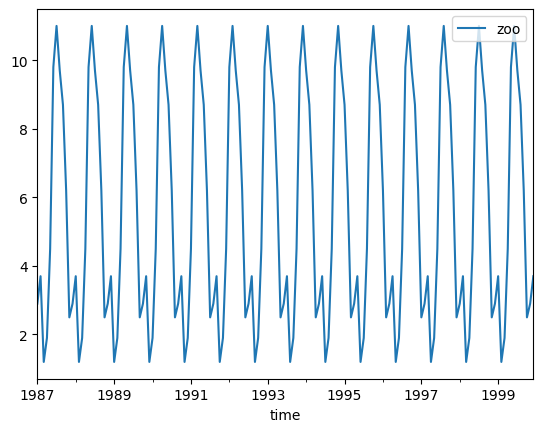

In [29]:
# Répliquer les données dans obs sur toute la série temporelle time_in_month
obs_replicated = pd.DataFrame(
    np.tile(obs.values, (len(time_in_month) // len(obs) + 1, 1))[: len(time_in_month)],
    index=time_in_month,
    columns=obs.columns,
)
obs_replicated.index.name = "time"

obs_replicated.plot()

In [30]:
obs_replicated

,zoo
time,
1987-01-01,2.9
1987-02-01,3.7
1987-03-01,1.2
1987-04-01,1.9
1987-05-01,4.5
...,...
1999-08-01,8.7
1999-09-01,6.2
1999-10-01,2.5


# Format with forcing


In [25]:
forcing = xr.open_zarr("./Barents_sea_forcing.zarr")
forcing

<xarray.Dataset> Size: 80MB
Dimensions:              (longitude: 1, time: 7305, depth: 3, latitude: 65)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float32 260B 70.0 70.08 70.08 ... 73.92 74.0
  * longitude            (longitude) int64 8B 20
  * time                 (time) datetime64[ns] 58kB 1998-01-01 ... 2017-12-31
Data variables: (12/13)
    T                    (longitude, time, depth, latitude) float64 11MB dask.array<chunksize=(1, 1827, 1, 33), meta=np.ndarray>
    U                    (longitude, time, depth, latitude) float64 11MB dask.array<chunksize=(1, 1827, 1, 33), meta=np.ndarray>
    V                    (longitude, time, depth, latitude) float64 11MB dask.array<chunksize=(1, 1827, 1, 33), meta=np.ndarray>
    mnkc_epi             (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    mnkc_hmlmeso         (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    mnkc_lmeso           (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    ...                   ...
    mnkc_mumeso          (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    mnkc_umeso           (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    npp                  (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    pelagic_layer_depth  (longitude, time, depth, latitude) float64 11MB dask.array<chunksize=(1, 1827, 1, 33), meta=np.ndarray>
    zeu                  (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
    zooc                 (longitude, time, latitude) float64 4MB dask.array<chunksize=(1, 1827, 33), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

In [50]:
obs_xr = xr.Dataset.from_dataframe(obs_replicated)
obs_xr = obs_xr.expand_dims({"latitude": forcing.latitude, "longitude": forcing.longitude, "layer": [0]})
obs_xr = obs_xr.transpose("time", "latitude", "longitude", "layer")
obs_xr.time.attrs = forcing.time.attrs
obs_xr.latitude.attrs = forcing.latitude.attrs
obs_xr.longitude.attrs = forcing.longitude.attrs
obs_xr.layer.attrs = {"axis": "Z"}
obs_xr = obs_xr.rename({"zoo": "night"})
obs_xr["night"] = obs_xr.night * COEF_DRY_TO_CARBON
obs_xr.night.attrs = {
    "long_name": "Zooplankton",
    "units": "g / m2",
    "type": "carbon",
    "coef_dry_to_carbon": COEF_DRY_TO_CARBON,
}
obs_xr

<xarray.Dataset> Size: 83kB
Dimensions:    (latitude: 65, longitude: 1, layer: 1, time: 156)
Coordinates:
  * latitude   (latitude) float32 260B 70.0 70.08 70.08 ... 73.83 73.92 74.0
  * longitude  (longitude) int64 8B 20
  * layer      (layer) int64 8B 0
  * time       (time) datetime64[ns] 1kB 1987-01-01 1987-02-01 ... 1999-12-01
Data variables:
    night      (time, latitude, longitude, layer) float64 81kB 1.16 ... 1.48

# Export


In [51]:
obs_xr.to_zarr("./zoo_1987_1999.zarr")